# Transfer Learning

In this notebook, you'll learn how to use pre-trained networks to solved challenging problems in computer vision. Specifically, you'll use networks trained on [ImageNet](http://www.image-net.org/) [available from torchvision](http://pytorch.org/docs/0.3.0/torchvision/models.html). 

ImageNet is a massive dataset with over 1 million labeled images in 1000 categories. It's used to train deep neural networks using an architecture called convolutional layers. I'm not going to get into the details of convolutional networks here, but if you want to learn more about them, please [watch this](https://www.youtube.com/watch?v=2-Ol7ZB0MmU).

Once trained, these models work astonishingly well as feature detectors for images they weren't trained on. Using a pre-trained network on images not in the training set is called transfer learning. Here we'll use transfer learning to train a network that can classify our cat and dog photos with near perfect accuracy.

With `torchvision.models` you can download these pre-trained networks and use them in your applications. We'll include `models` in our imports now.

In [48]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
import os
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

import numpy as np

import PIL
from PIL import Image
print(PIL.PILLOW_VERSION)

6.2.2


In [27]:
from google.colab import drive
drive.mount('/content/drive')

!ls -l "/content/drive/My Drive/checkpoints"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
total 1081566
-rw------- 1 root root  65984065 Jan 22 22:47 cat_dogs_densenet_121.pth
-rw------- 1 root root  63352950 Jan 22 23:18 cat_dogs_densenet_121_v2.pth
-rw------- 1 root root 489091900 Jan 21 22:47 cat_dogs_resnet152.pth
-rw------- 1 root root 489093553 Jan 22 21:49 cat_dogs_resnet152_v2.pth


Most of the pretrained models require the input to be 224x224 images. Also, we'll need to match the normalization used when the models were trained. Each color channel was normalized separately, the means are `[0.485, 0.456, 0.406]` and the standard deviations are `[0.229, 0.224, 0.225]`.

In [0]:
base_path = "./"
dataset_zip = "Cat_Dog_data.zip"
base_url = "https://s3.amazonaws.com/content.udacity-data.com/nd089/"

In [0]:
def download_dataset(base_path, base_url, dataset_zip):
  dir_name, _ = os.path.splitext(dataset_zip)
  if os.path.exists(dir_name):
    print("Data already exists at: {}".format(dir_name))
    return 

  fullpath = os.path.join(base_url, dataset_zip)
  !wget $fullpath
  !unzip -q $dataset_zip -d $base_path

In [4]:
download_dataset(base_path, base_url, dataset_zip)

--2020-01-22 23:26:22--  https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.236.181
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.236.181|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 580495262 (554M) [application/zip]
Saving to: ‘Cat_Dog_data.zip’

Cat_Dog_data.zip    100%[===================>] 553.60M  91.5MB/s    in 6.2s    

2020-01-22 23:26:28 (88.9 MB/s) - ‘Cat_Dog_data.zip’ saved [580495262/580495262]



In [0]:
data_dir = 'Cat_Dog_data'

# TODO: Define transforms for the training data and testing data
train_transforms = transforms.Compose([ transforms.RandomRotation(35), # Apply a random rotation of 35 degrees
                                       transforms.RandomResizedCrop(224), # Crop the given PIL Image to random size and aspect ratio.
                                       transforms.RandomGrayscale(p=0.05), # Apply random grayscale to the picture with a probability of 5%
                                       transforms.RandomHorizontalFlip(p=0.15), # Horizontal Flip Random with probability of 15%
                                       transforms.ToTensor(), # Transform to a Tensor
                                       transforms.Normalize([0.485, 0.456, 0.406],  # Normalize with the mean and std by each channel
                                                            [0.229, 0.224, 0.225])
                                       ])

test_transforms = train_transforms = transforms.Compose([ 
                                       transforms.Resize(255),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor()
                                       ])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=256, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=256)

We can load in a model such as [DenseNet](http://pytorch.org/docs/0.3.0/torchvision/models.html#id5). Let's print out the model architecture so we can see what's going on.

In [6]:
model = models.densenet121(pretrained=True)
model.classifier

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 62.3MB/s]


Linear(in_features=1024, out_features=1000, bias=True)

This model is built out of two main parts, the features and the classifier. The features part is a stack of convolutional layers and overall works as a feature detector that can be fed into a classifier. The classifier part is a single fully-connected layer `(classifier): Linear(in_features=1024, out_features=1000)`. This layer was trained on the ImageNet dataset, so it won't work for our specific problem. That means we need to replace the classifier, but the features will work perfectly on their own. In general, I think about pre-trained networks as amazingly good feature detectors that can be used as the input for simple feed-forward classifiers.

In [0]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False



In [0]:
from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1024, 500)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(500, 2)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))  

In [9]:
model.classifier = classifier
model.classifier 

Sequential(
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=500, out_features=2, bias=True)
  (output): LogSoftmax()
)

With our model built, we need to train the classifier. However, now we're using a **really deep** neural network. If you try to train this on a CPU like normal, it will take a long, long time. Instead, we're going to use the GPU to do the calculations. The linear algebra computations are done in parallel on the GPU leading to 100x increased training speeds. It's also possible to train on multiple GPUs, further decreasing training time.

PyTorch, along with pretty much every other deep learning framework, uses [CUDA](https://developer.nvidia.com/cuda-zone) to efficiently compute the forward and backwards passes on the GPU. In PyTorch, you move your model parameters and other tensors to the GPU memory using `model.to('cuda')`. You can move them back from the GPU with `model.to('cpu')` which you'll commonly do when you need to operate on the network output outside of PyTorch. As a demonstration of the increased speed, I'll compare how long it takes to perform a forward and backward pass with and without a GPU.

In [0]:
import time

In [11]:
for device in ['cpu', 'cuda']:

    criterion = nn.NLLLoss()
    # Only train the classifier parameters, feature parameters are frozen
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

    model.to(device)

    for ii, (inputs, labels) in enumerate(trainloader):

        # Move input and label tensors to the GPU
        inputs, labels = inputs.to(device), labels.to(device)

        start = time.time()

        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if ii==3:
            break
        
    print(f"Device = {device}; Time per batch: {(time.time() - start)/3:.3f} seconds")

Device = cpu; Time per batch: 10.870 seconds
Device = cuda; Time per batch: 0.013 seconds


You can write device agnostic code which will automatically use CUDA if it's enabled like so:
```python
# at beginning of the script
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

...

# then whenever you get a new Tensor or Module
# this won't copy if they are already on the desired device
input = data.to(device)
model = MyModule(...).to(device)
```

From here, I'll let you finish training the model. The process is the same as before except now your model is much more powerful. You should get better than 95% accuracy easily.

>**Exercise:** Train a pretrained models to classify the cat and dog images. Continue with the DenseNet model, or try ResNet, it's also a good model to try out first. Make sure you are only training the classifier and the parameters for the features part are frozen.

In [0]:
def train_model(model, train_loader, test_loader, criterion, optimizer, device, epochs=5):
    '''
    train the model with accuracy and training / testing loss
    
    parameters
    ----------
    model: Classifier object to apply the trainining on.
    epochs: int, optional default: 30, number of iterations for training
    '''
    steps = 0
    print_every = 10
    # train_losses and test_losses to be used later for plotting 
    train_losses, test_losses = [], []
    for e in range(epochs):
        running_loss = 0
       
        for images, labels in train_loader:
            steps +=1
            # Move images and labels tensors to the default device
            images, labels = images.to(device), labels.to(device)
          
            # Refresh the gradients to zero 
            optimizer.zero_grad()

            # Forward pass
            log_ps = model.forward(images)
            # Calculate loss function 
            loss = criterion(log_ps, labels)
            # Propagate the loss
            loss.backward()

            # Update the weights 
            optimizer.step()

            running_loss += loss.item() 
            
            if steps % print_every == 0:
              print("Validation step: {}".format(steps))
              test_loss = 0 
              accuracy = 0 
              ## Validation pass
              with torch.no_grad(): # Don't use the gradients
                  model.eval()
                  for images, labels in test_loader: # Use the test data
                    
                      # Move images and labels tensors to the default device
                      images, labels = images.to(device), labels.to(device)
                      
                      # forward pass 
                      out = model.forward(images)
                      # calculate the test loss
                      test_loss += criterion(out, labels)
                      # Calculate the probabilities
                      probabilities = torch.exp(out)
                      # Calculate the top 1 class
                      top_p, top_class = probabilities.topk(1, dim=1)
                      # Compare the top class against the actual labels
                      equals = top_class == labels.view(*top_class.shape)
                      # Calculate accuracy
                      tensorType = torch.FloatTensor if device == 'cpu' else torch.cuda.FloatTensor 
                      accuracy += torch.mean(equals.type(tensorType))
              
              model.train() 
              train_losses.append(running_loss / len(train_loader))
              test_losses.append(test_loss / len(test_loader))

              print("Epoch: {}/{}.. ".format(e+1, epochs),
                    "Training Loss: {:.5f}.. ".format(train_losses[-1]),
                    "Test Loss: {:.5f}.. ".format(test_losses[-1]),
                    "Test Accuracy: {:.3f}".format((accuracy/len(test_loader))*100))
    return model, optimizer,  train_losses, test_losses

In [13]:
# Transfer Learning. Using a pretrained model. In this case DenseNet 201
model = models.densenet201(pretrained=True)
# Check out the last layer, identified as "classifier"
model.classifier

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:01<00:00, 72.9MB/s]


Linear(in_features=1920, out_features=1000, bias=True)

In [0]:
# Freeze parameters :) 
for param in model.parameters():
    param.requires_grad = False

In [0]:
from collections import OrderedDict

# Define the CatDogClassifier network to be used as the last layer of the DenseNet 201
cat_dog_clf = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1920, 512)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(512, 2)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))  

In [16]:
# Update the model 
model.classifier = cat_dog_clf # replace the last layer with the layers defined by your own model
# Define the loss function 
criterion = nn.NLLLoss()
# Define the optimizer to be used for updating the weights
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
# Last layer will look like this 
model.classifier

Sequential(
  (fc1): Linear(in_features=1920, out_features=512, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (output): LogSoftmax()
)

In [17]:
# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on {}".format(device))
model.to(device);

Running on cuda


In [18]:
# Uncomment if you want to train the model ( last layer only - classifier) for 2 epochs
modelTrained, optimizer, train_loss, test_loss = train_model(model, trainloader, testloader, criterion, optimizer, device, epochs=2)

Validation step: 10
Epoch: 1/2..  Training Loss: 0.02580..  Test Loss: 0.06546..  Test Accuracy: 97.659
Validation step: 20
Epoch: 1/2..  Training Loss: 0.03199..  Test Loss: 0.05668..  Test Accuracy: 97.753
Validation step: 30
Epoch: 1/2..  Training Loss: 0.03949..  Test Loss: 0.07611..  Test Accuracy: 97.131
Validation step: 40
Epoch: 1/2..  Training Loss: 0.04569..  Test Loss: 0.06683..  Test Accuracy: 97.533
Validation step: 50
Epoch: 1/2..  Training Loss: 0.05050..  Test Loss: 0.05744..  Test Accuracy: 97.734
Validation step: 60
Epoch: 1/2..  Training Loss: 0.05571..  Test Loss: 0.03692..  Test Accuracy: 98.308
Validation step: 70
Epoch: 1/2..  Training Loss: 0.06025..  Test Loss: 0.03670..  Test Accuracy: 98.465
Validation step: 80
Epoch: 1/2..  Training Loss: 0.06506..  Test Loss: 0.03548..  Test Accuracy: 98.453
Validation step: 90
Epoch: 2/2..  Training Loss: 0.00071..  Test Loss: 0.04402..  Test Accuracy: 98.203
Validation step: 100
Epoch: 2/2..  Training Loss: 0.00421..  Tes

In [0]:
checkpoint_name = "/content/drive/My Drive/checkpoints/cat_dogs_densenet_201.pth"

In [0]:
def save_model(model, optimizer, checkpoint_name):
  '''
  save_model will create the checkpoint dictionary and save the model to a file

  parameters
  ----------
  model, pytorch trained model
  checkpoint_name: string, fullpath to where the checkpoint will be stored
  '''

  # Define the checkpoint to be able to load the model later :) 
  # Save the state_dict, input and output size, optimizer state
  # Last Layer, and Architecture you trained on. 
  # Note: checkpoint dict should be modified accordingly to the model you are using
  checkpoint = {'input_size': 1920,
                'output_size': 2,
                'epochs': 2,
                'batch_size': 256,
                'optimizer_state': optimizer.state_dict(),
                'classifier': model.classifier,
                'architecture': models.densenet201(pretrained=True),
                'state_dict': model.state_dict()}

  torch.save(checkpoint,checkpoint_name)

In [0]:
def load_checkpoint(filepath):
    '''
    load_checkpoint, will load the model from a checkpoint file

    parameters
    ---------
    filepath: string, fullpath to read the checkpoint file.

    returns
    -------
    torch model
    '''
    checkpoint = torch.load(filepath) # Load the model
    model = checkpoint['architecture'] # Load the architecture
    model.load_state_dict(checkpoint['state_dict'], strict=False)
    optimizer.load_state_dict(checkpoint['optimizer_state'])
    epochs = checkpoint['epochs'] # Load the epochs you trained on 
    model.classifier = checkpoint['classifier'] # Override the last layer

    return model

In [28]:
save_model(modelTrained, optimizer, checkpoint_name)

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type LogSoftmax. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/d

In [29]:
model_cat_dogs = load_checkpoint(checkpoint_name)
model_cat_dogs.classifier

Sequential(
  (fc1): Linear(in_features=1920, out_features=512, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (output): LogSoftmax()
)

In [0]:
def update_labels(classes):
  labels = []
  cat_to_name = {'0': 'cat', '1': 'dog'}
  for x in classes.cpu().numpy().squeeze():
    labels.append(cat_to_name[str(x)])
  
  return labels

In [0]:
def process_image(img_path):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # Process a PIL image for use in a PyTorch model
    img = Image.open(img_path)
    
    transform = transforms.Compose([  transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],  
                                                           [0.229, 0.224, 0.225])])
    image_tensor = transform(img)
    
    return image_tensor

In [0]:
def predict(image_path, model, topk=2):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    model.cuda()
    # let us process the image 
    img = process_image(image_path)
    # Convert 2D image to 1D vector
    image = img.unsqueeze_(0)

    # Calculate the class probabilities (softmax) for img
    with torch.no_grad():
      model.eval()
      output = model.forward(image.cuda())
      possibilities, predicted = torch.topk(output, topk)
      
    ps = F.softmax(possibilities,dim=1)
    
    return ps, predicted

In [0]:
def check(img, probs, classes):
    probs = probs.data.numpy().squeeze()
    img = Image.open(img)
    
    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    
    ax1.imshow(img)
    ax1.axis('off')
    ax2.barh(np.arange(2), probs)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(2))
    ax2.set_yticklabels(update_labels(classes), size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)



    plt.tight_layout()

In [73]:
from google.colab import files

uploaded=files.upload()

Saving labrador.jpg to labrador.jpg


In [74]:
img_path = list(uploaded.keys())[0]
img = process_image(img_path)
print(img.shape)

torch.Size([3, 224, 224])


In [75]:
probs, preds = predict(img_path,model_cat_dogs)
probs, preds

(tensor([[0.9503, 0.0497]], device='cuda:0'),
 tensor([[1, 0]], device='cuda:0'))

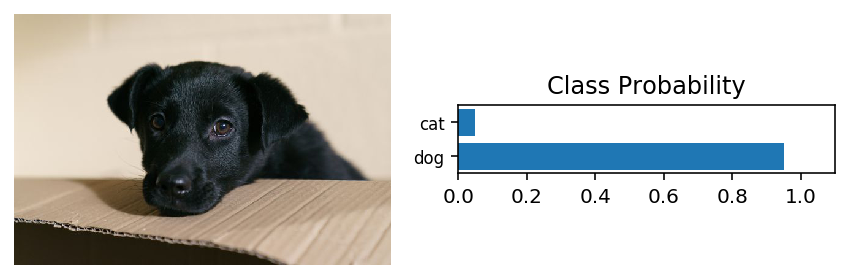

In [76]:
check(img_path, probs.cpu(), preds.cpu())